In [36]:
# %pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations --user


In [17]:
import os
import cv2
import time
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [18]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [19]:
images.as_numpy_iterator().next()

b'data\\images\\45_1_0_20170119192452937.jpg'

In [20]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [21]:
images = images.map(load_image)

In [22]:
images.as_numpy_iterator().next()

array([[[149, 131, 121],
        [149, 131, 121],
        [149, 131, 121],
        ...,
        [154,  95,  65],
        [155,  94,  65],
        [157,  93,  65]],

       [[149, 131, 121],
        [149, 131, 121],
        [149, 131, 121],
        ...,
        [154,  95,  65],
        [155,  94,  65],
        [157,  93,  65]],

       [[149, 131, 121],
        [149, 131, 121],
        [149, 131, 121],
        ...,
        [154,  95,  65],
        [155,  94,  65],
        [157,  93,  65]],

       ...,

       [[189, 217, 254],
        [189, 217, 254],
        [189, 217, 254],
        ...,
        [145,  85,  35],
        [146,  86,  36],
        [146,  86,  36]],

       [[188, 216, 253],
        [188, 216, 253],
        [188, 216, 253],
        ...,
        [145,  85,  33],
        [144,  84,  34],
        [144,  84,  34]],

       [[188, 216, 253],
        [188, 216, 253],
        [188, 216, 253],
        ...,
        [145,  85,  33],
        [144,  84,  34],
        [144,  84,  34]]

In [23]:

type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [24]:
image_generator = images.batch(4).as_numpy_iterator()

In [25]:
plot_images = image_generator.next()

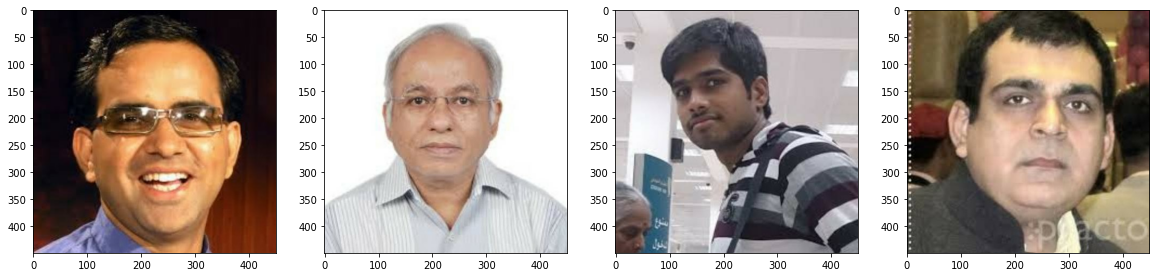

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [27]:
400*.7

280.0

In [28]:
400*.15

60.0

In [29]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [30]:
import albumentations as alb

In [31]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [32]:
img = cv2.imread(os.path.join('data','train', 'images','4_0_3_20170119180525502.jpg'))

In [33]:
with open(os.path.join('data', 'train', 'labels', '4_0_3_20170119180525502.json'), 'r') as f:
    label = json.load(f)

In [34]:
label['shapes'][0]['label']

'Face'

In [35]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [36]:
coords

[214.9261744966443, 71.14093959731544, 320.2953020134228, 197.98657718120805]

In [37]:
coords = list(np.divide(coords, [450,450,450,450]))

In [38]:
coords

[0.477613721103654,
 0.1580909768829232,
 0.7117673378076063,
 0.43997017151379564]

In [39]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])

In [40]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [41]:
augmented['bboxes']

[(0.477613721103654,
  0.1580909768829232,
  0.7117673378076063,
  0.43997017151379564)]

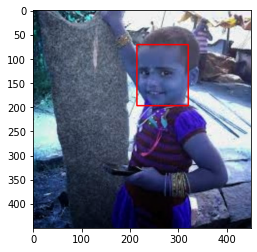

In [42]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [43]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [450,450,450,450]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [44]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [45]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [46]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [47]:
train_images.as_numpy_iterator().next()

array([[[0.07058824, 0.06666667, 0.09019608],
        [0.08216912, 0.075     , 0.09969363],
        [0.09852941, 0.08627451, 0.10735294],
        ...,
        [0.30079657, 0.12824754, 0.26942402],
        [0.3041054 , 0.12432598, 0.26783088],
        [0.31433824, 0.13639706, 0.27022058]],

       [[0.07022059, 0.0627451 , 0.0958946 ],
        [0.08388481, 0.07199755, 0.10030637],
        [0.10545343, 0.08584559, 0.11329657],
        ...,
        [0.315625  , 0.14307599, 0.2793505 ],
        [0.31378677, 0.12996323, 0.2711397 ],
        [0.3167892 , 0.13155638, 0.26813725]],

       [[0.07794118, 0.06617647, 0.10637255],
        [0.09515931, 0.08241422, 0.11672794],
        [0.10980392, 0.09019608, 0.11764706],
        ...,
        [0.3367647 , 0.16813725, 0.2797794 ],
        [0.32199755, 0.13866422, 0.27236518],
        [0.3253064 , 0.13578431, 0.26550245]],

       ...,

       [[0.7176471 , 0.7411765 , 0.8039216 ],
        [0.7176471 , 0.7411765 , 0.8039216 ],
        [0.7171569 , 0

In [48]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [49]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [50]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [51]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [52]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2167, 0.2006, 0.786 , 0.924 ], dtype=float16))

In [53]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(16800, 16800, 3600, 3600, 3600, 3600)

In [54]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(17100)
train = train.batch(8)
train = train.prefetch(4)

In [55]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(3900)
test = test.batch(8)
test = test.prefetch(4)

In [56]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(3900)
val = val.batch(8)
val = val.prefetch(4)

In [57]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [58]:

data_samples = train.as_numpy_iterator()

In [59]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


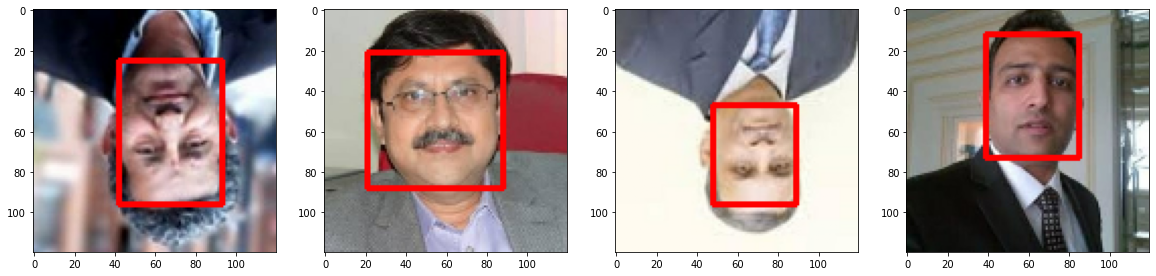

In [60]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [61]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [62]:
vgg = VGG16(include_top=False)

In [68]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [69]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [70]:
facetracker = build_model()

In [71]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [72]:
X, y = train.as_numpy_iterator().next()

In [73]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 3s 3s/step


In [74]:
classes, coords

(array([[0.7517438 ],
        [0.8027936 ],
        [0.6972646 ],
        [0.7019477 ],
        [0.7630662 ],
        [0.84010226],
        [0.81413263],
        [0.74374294]], dtype=float32),
 array([[0.46166822, 0.3751681 , 0.61648464, 0.4832372 ],
        [0.3879721 , 0.34907258, 0.4760262 , 0.43940035],
        [0.46115863, 0.43867707, 0.55307144, 0.4082088 ],
        [0.37275288, 0.34583747, 0.4677517 , 0.5384117 ],
        [0.4682881 , 0.46129695, 0.5416312 , 0.44293734],
        [0.35665074, 0.42099187, 0.46001515, 0.53736365],
        [0.43109745, 0.3587907 , 0.5140028 , 0.52690285],
        [0.40066713, 0.46904424, 0.45839947, 0.30148032]], dtype=float32))

In [75]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [76]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [77]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [78]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [79]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.412252>

In [80]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.2707296>

In [81]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.412252>

In [82]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [83]:
model = FaceTracker(facetracker)

In [84]:
model.compile(opt, classloss, regressloss)

In [85]:
logdir='logs'

In [86]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [88]:
hist = model.fit(train, epochs=1, validation_data=val, callbacks=[tensorboard_callback])

2100/2100 [==============================] - 10797s 5s/step - total_loss: 0.0179 - class_loss: 1.1783e-05 - regress_loss: 0.0179 - val_total_loss: 0.1310 - val_class_loss: 5.0366e-06 - val_regress_loss: 0.1310


In [89]:
hist.history

{'total_loss': [0.003430682932958007],
 'class_loss': [6.593996658921242e-05],
 'regress_loss': [0.0033977129496634007],
 'val_total_loss': [0.13096930086612701],
 'val_class_loss': [5.036640686739702e-06],
 'val_regress_loss': [0.13096678256988525]}

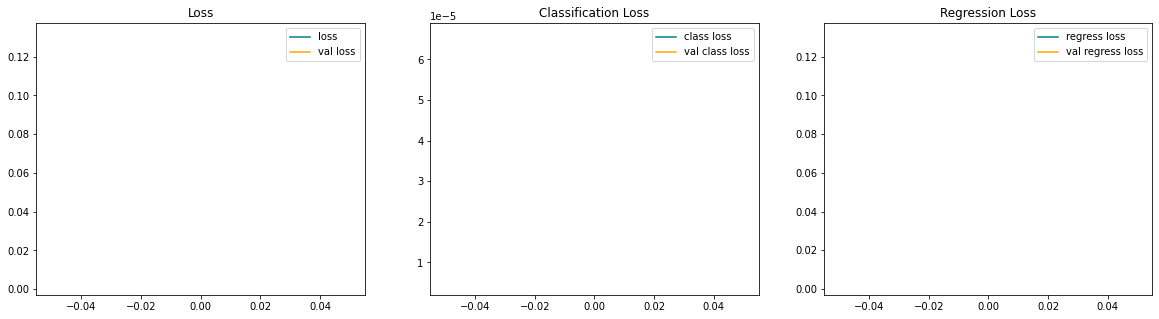

In [91]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [111]:
test_data = test.as_numpy_iterator()

In [112]:
test_sample = test_data.next()

In [113]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 3s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


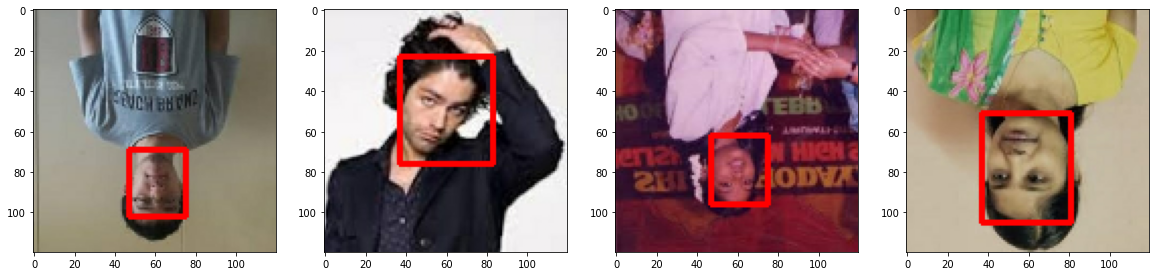

In [114]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [96]:
from tensorflow.keras.models import load_model

In [97]:
facetracker.save('facetracker.h5')

In [98]:
facetracker = load_model('facetracker.h5')

In [137]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

TypeError: 'NoneType' object is not subscriptable